<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np
import random
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import f1_score 
from sklearn.metrics import roc_auc_score
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_score

In [2]:
df = pd.read_csv('/datasets/Churn.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


В столбце Tenure присутствуют пропуски, восстановим их, предполагаея, что клиенты в одних странах в зависимости возраста имеют одинаковый срок жизни в качестве клиента банка.


In [3]:
df[df['Tenure'].isna()].head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
30,31,15589475,Azikiwe,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
48,49,15766205,Yin,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
51,52,15768193,Trevisani,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
53,54,15702298,Parkhill,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
60,61,15651280,Hunter,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0


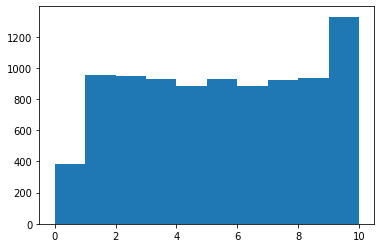

In [4]:
plt.hist(df['Tenure'])
plt.show()

In [5]:
df['Tenure'] = df['Tenure'].fillna(df.groupby(['Geography','Age'])['Tenure'].transform('median'))

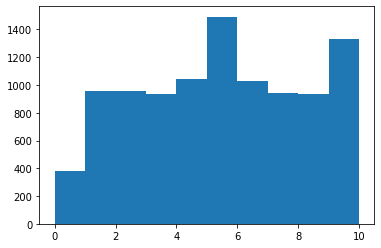

In [6]:
plt.hist(df['Tenure'])
plt.show()

Преобразуем значения столбцов в целочисленные

In [7]:
df['Tenure'] = df['Tenure'].round()
df['Tenure'] = df['Tenure'].astype('int64')

In [8]:
df.dtypes

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

 Удалим из таблицы столбцы RowNumber, CustomerId,  Surname, т.к. они не несут никакой пользы для исследования

In [9]:
df = df.drop(['RowNumber','CustomerId','Surname'],axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


Преобразуем категориальные признаки в численные с помощью техники OHE

In [10]:
df = pd.get_dummies(df, drop_first=True)

In [11]:
# Код ревьюера

df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        10000 non-null  int64  
 1   Age                10000 non-null  int64  
 2   Tenure             10000 non-null  int64  
 3   Balance            10000 non-null  float64
 4   NumOfProducts      10000 non-null  int64  
 5   HasCrCard          10000 non-null  int64  
 6   IsActiveMember     10000 non-null  int64  
 7   EstimatedSalary    10000 non-null  float64
 8   Exited             10000 non-null  int64  
 9   Geography_Germany  10000 non-null  uint8  
 10  Geography_Spain    10000 non-null  uint8  
 11  Gender_Male        10000 non-null  uint8  
dtypes: float64(2), int64(7), uint8(3)
memory usage: 732.5 KB


In [13]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

Доля положительных ответов в 4 раза меньше отрицательных. Налицо дисбаланс классов в пользу отрицательного класса в соотношении 8:2. Если мы будем всех людей прогнозировать, что они не уйдут из банка, то в 80% случаев мы будем правы

Разобьем данные на обучающую, валидационную и тестовую выборки в соотношении 60-20-20.

In [14]:
features = df.drop('Exited',axis=1) # создаем переменную с признаками
target = df['Exited']  # создаем переменную с  целевым признаком

features_t, features_valid, target_t, target_valid = train_test_split(
    features, target, test_size=0.2,train_size=0.8, random_state=12345)
features_train, features_test, target_train, target_test = train_test_split(
    features_t, target_t, test_size=0.25,train_size=0.75, random_state=12345)
print('Размер получившихся выборок: \n')
print('train:',features_train.shape,target_train.shape)
print('valid:',features_valid.shape,target_valid.shape)
print('test:',features_test.shape,target_test.shape)

Размер получившихся выборок: 

train: (6000, 11) (6000,)
valid: (2000, 11) (2000,)
test: (2000, 11) (2000,)


Масштабируем количественные признаки

In [15]:
pd.options.mode.chained_assignment = None # игнорируем предупреждение SettingsWithCopy
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts','HasCrCard','IsActiveMember','EstimatedSalary']
scaler  = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric]) 
features_test[numeric] = scaler.transform(features_test[numeric]) 


## Исследование задачи

На данном этапе рассмотрим 3 алгоритма классификации:
- Решающее дерево
- Случайный лес
- Логистическая регрессия

Найдем наилучший алгоритм, определяя в процессе оптимальные гиперпараметры каждого метода.

In [16]:
best_model_tree = None
best_f1_tree = 0
best_max_depth=0
best_min_samples_leaf = 0
for leaf in range(1,100,38):
    for depth in range(1,16):
        model_tree = DecisionTreeClassifier(random_state=12345, min_samples_leaf=leaf, max_depth=depth)
        model_tree.fit(features_train,target_train)
        predicted_valid_tree = model_tree.predict(features_valid)
        f1_tree = f1_score(target_valid,predicted_valid_tree)
        #print("min_samples_leaf =",leaf,": ",result)
        if f1_tree > best_f1_tree:
            best_model_tree = model_tree # сохраняем наилучшую модель
            best_f1_tree = f1_tree #  сохраняем наилучшее значение метрики F1 на валидационных данных
            best_predicted_valid_tree = predicted_valid_tree
            best_max_depth = depth
            best_min_samples_leaf = leaf
print("F1 мера наилучшей модели алгоритма Решающее дерево равна:", best_f1_tree.round(3),'\nпри гиперпараметрах: max_depth =',best_max_depth,'и min_samples_leaf=', best_min_samples_leaf)
#print("Матрица ошибок: \n",confusion_matrix(target_valid, best_predicted_valid_tree))

F1 мера наилучшей модели алгоритма Решающее дерево равна: 0.619 
при гиперпараметрах: max_depth = 10 и min_samples_leaf= 39


In [17]:
best_model_forest = None
best_f1_forest= 0
best_max_depth=0
best_n_estimators = 0
for est in range(1,51,13):
    for depth in range(1,16):
        model_forest = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model_forest.fit(features_train,target_train)
        predicted_valid_forest = model_forest.predict(features_valid)
        f1_forest = f1_score(target_valid,predicted_valid_forest)
        #print("min_samples_leaf =",leaf,": ",result)
        if f1_forest > best_f1_forest:
            best_model_forest = model_forest# сохраните наилучшую модель
            best_f1_forest = f1_forest#  сохраните наилучшее значение метрики accuracy на валидационных данных
            best_predicted_valid_forest = predicted_valid_forest
            best_max_depth = depth
            best_n_estimators = est
print("F1 мера наилучшей модели алгоритма Случайный Лес равна:", best_f1_forest.round(3),'\nпри гиперпараметрах: max_depth =',best_max_depth,'и n_estimators=', best_n_estimators)
#print("Матрица ошибок: \n",confusion_matrix(target_valid, best_predicted_valid_forest))

F1 мера наилучшей модели алгоритма Случайный Лес равна: 0.583 
при гиперпараметрах: max_depth = 12 и n_estimators= 14


In [18]:
model_lr = LogisticRegression(random_state=12345, solver='lbfgs')
model_lr.fit(features_train,target_train)
predicted_valid_lr = model_lr.predict(features_valid)
f1_lr = f1_score(target_valid,predicted_valid_lr)
print("F1 мера модели алгоритма Логистическая регрессия равна:", f1_lr.round(3))
#print("Матрица ошибок: \n",confusion_matrix(target_valid, predicted_valid_lr))

F1 мера модели алгоритма Логистическая регрессия равна: 0.304


Без учета дисбаланса лучшая модель получилась при алгоритме Случайное дерево. 

Судя по полученным матрицам, во всех трех методах отстутсвует баланс классов, в каждоим из них высока доля ответов True Negative

## Борьба с дисбалансом

Теперь для всех вышеописанных алгоритмов сделаем веса классов сбалансированными, т.е. применим в методах аргумент class_weight='balanced'. Дополнительно к параметру F1 рассчитаем параметр roc_auc_score

In [19]:
best_model_tree_balanced = None
best_f1_tree_balanced = 0
best_max_depth=0
best_min_samples_leaf = 0
for leaf in range(10,101,10):
    for depth in range(1,16):
        model_tree_balanced = DecisionTreeClassifier(random_state=12345, min_samples_leaf=leaf, max_depth=depth,class_weight='balanced')
        model_tree_balanced.fit(features_train,target_train)
        predicted_valid_tree_balanced = model_tree_balanced.predict(features_valid)
        f1_tree = f1_score(target_valid,predicted_valid_tree_balanced)
        #print("min_samples_leaf =",leaf,": ",result)
        if f1_tree > best_f1_tree_balanced:
            best_model_tree_balanced = model_tree_balanced # сохраняем наилучшую модель
            best_f1_tree_balanced = f1_tree #  сохраняем наилучшее значение метрики F1 на валидационных данных
            best_predicted_valid_tree_balanced = predicted_valid_tree_balanced
            best_max_depth = depth
            best_min_samples_leaf = leaf
print("F1 мера наилучшей модели алгоритма Решающее дерево равна:", best_f1_tree_balanced.round(3),'\nпри гиперпараметрах: max_depth =',best_max_depth,'и min_samples_leaf=', best_min_samples_leaf)
probabilities_valid = best_model_tree_balanced.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('Auc_roc:',auc_roc.round(3))

F1 мера наилучшей модели алгоритма Решающее дерево равна: 0.611 
при гиперпараметрах: max_depth = 6 и min_samples_leaf= 30
Auc_roc: 0.845


In [20]:
best_model_forest_balanced = None
best_f1_forest_balanced= 0
best_max_depth=0
best_n_estimators = 0
for est in range(10,101,10):
    for depth in range(1,16):
        model_forest_balanced = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth,class_weight='balanced')
        model_forest_balanced.fit(features_train,target_train)
        predicted_valid_forest_balanced = model_forest_balanced.predict(features_valid)
        f1_forest_balanced = f1_score(target_valid,predicted_valid_forest_balanced)
        #print("min_samples_leaf =",leaf,": ",result)
        if f1_forest_balanced > best_f1_forest_balanced:
            best_model_forest_balanced = model_forest_balanced# сохраните наилучшую модель
            best_f1_forest_balanced = f1_forest_balanced#  сохраните наилучшее значение метрики accuracy на валидационных данных
            best_predicted_valid_forest_balanced = predicted_valid_forest_balanced
            best_max_depth = depth
            best_n_estimators = est
print("F1 мера наилучшей модели алгоритма Случайный Лес равна:", best_f1_forest_balanced.round(3),'\nпри гиперпараметрах: max_depth =',best_max_depth,'и n_estimators=', best_n_estimators)
best_model_forest_balanced
probabilities_valid = best_model_forest_balanced.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('Auc_roc:',auc_roc.round(3))

F1 мера наилучшей модели алгоритма Случайный Лес равна: 0.652 
при гиперпараметрах: max_depth = 8 и n_estimators= 50
Auc_roc: 0.871


In [21]:
model_lr_balanced = LogisticRegression(random_state=12345, solver='liblinear',class_weight='balanced')
model_lr_balanced.fit(features_train,target_train)
predicted_valid_lr_balanced = model_lr_balanced.predict(features_valid)
f1_lr_balanced = f1_score(target_valid,predicted_valid_lr_balanced)
print("F1 мера модели алгоритма Логистическая регрессия равна:", f1_lr_balanced.round(3))

probabilities_valid = model_lr_balanced.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('Auc_roc:',auc_roc.round(3))

F1 мера модели алгоритма Логистическая регрессия равна: 0.502
Auc_roc: 0.764


Проведем поочередно увелечение выборок и рассчитаем значения меры F1. Значение для repeat 4.

In [22]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled
features_upsampled, target_upsampled = upsample(features_train, target_train,4)

In [23]:
best_model_tree_ups = None
best_f1_tree_ups = 0
best_max_depth=0
best_min_samples_leaf = 0
for leaf in range(10,101,10):
    for depth in range(1,16):
        model_tree_ups = DecisionTreeClassifier(random_state=12345, min_samples_leaf=leaf, max_depth=depth)
        model_tree_ups.fit(features_upsampled, target_upsampled)
        predicted_valid_tree_ups = model_tree_ups.predict(features_valid)
        f1_tree_ups = f1_score(target_valid,predicted_valid_tree_ups)
        #print("min_samples_leaf =",leaf,": ",result)
        if f1_tree_ups > best_f1_tree_ups:
            best_model_tree_ups = model_tree_ups # сохраняем наилучшую модель
            best_f1_tree_ups = f1_tree_ups #  сохраняем наилучшее значение метрики F1 на валидационных данных
            best_predicted_valid_tree_ups = predicted_valid_tree_ups
            best_max_depth = depth
            best_min_samples_leaf = leaf
print("F1 мера наилучшей модели алгоритма Решающее дерево равна:", best_f1_tree_ups.round(3),'\nпри гиперпараметрах: max_depth =',best_max_depth,'и min_samples_leaf=', best_min_samples_leaf)
probabilities_valid = best_model_tree_ups.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('Auc_roc:',auc_roc.round(3))

F1 мера наилучшей модели алгоритма Решающее дерево равна: 0.623 
при гиперпараметрах: max_depth = 8 и min_samples_leaf= 80
Auc_roc: 0.854


In [24]:
best_model_forest_ups = None
best_f1_forest_ups= 0
best_max_depth=0
best_n_estimators = 0
for est in range(10,101,10):
    for depth in range(1,16):
        model_forest_ups = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model_forest_ups.fit(features_upsampled, target_upsampled)
        predicted_valid_forest_ups = model_forest_ups.predict(features_valid)
        f1_forest_ups = f1_score(target_valid,predicted_valid_forest_ups)
        #print("min_samples_leaf =",leaf,": ",result)
        if f1_forest_ups > best_f1_forest_ups:
            best_model_forest_ups = model_forest_ups# сохраните наилучшую модель
            best_f1_forest_ups = f1_forest_ups #  сохраним наилучшее значение метрики accuracy на валидационных данных
            best_predicted_valid_forest_ups = predicted_valid_forest_ups
            best_max_depth = depth
            best_n_estimators = est
print("F1 мера наилучшей модели алгоритма Случайный Лес равна:", best_f1_forest_ups.round(3),'\nпри гиперпараметрах: max_depth =',best_max_depth,'и n_estimators=', best_n_estimators)

probabilities_valid = best_model_forest_ups.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('Auc_roc:',auc_roc.round(3))

F1 мера наилучшей модели алгоритма Случайный Лес равна: 0.647 
при гиперпараметрах: max_depth = 11 и n_estimators= 90
Auc_roc: 0.865


In [25]:
model_lr_ups = LogisticRegression(random_state=12345, solver='liblinear')
model_lr_ups.fit(features_upsampled, target_upsampled)
predicted_valid_ups = model_lr_ups.predict(features_valid)  

print("F1 мера модели алгоритма Логистическая регрессия при увеличении выборки равна:", f1_score(target_valid, predicted_valid_ups).round(3))

probabilities_valid = model_lr_ups.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('Auc_roc:',auc_roc.round(3))

F1 мера модели алгоритма Логистическая регрессия при увеличении выборки равна: 0.504
Auc_roc: 0.764


Проведем поочередно уменьшение выборок и рассчитаем значения меры F1. Значение для repeat 0,25

In [26]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

In [27]:
best_model_tree_ds = None
best_f1_tree_ds = 0
best_max_depth=0
best_min_samples_leaf = 0
for leaf in range(10,101,10):
    for depth in range(1,16):
        model_tree_ds = DecisionTreeClassifier(random_state=12345, min_samples_leaf=leaf, max_depth=depth)
        model_tree_ds.fit(features_downsampled,target_downsampled)
        predicted_valid_tree_ds = model_tree_ds.predict(features_valid)
        f1_tree_ds = f1_score(target_valid,predicted_valid_tree_ds)
        #print("min_samples_leaf =",leaf,": ",result)
        if f1_tree_ds > best_f1_tree_ds:
            best_model_tree_ds = model_tree_ds # сохраняем наилучшую модель
            best_f1_tree_ds = f1_tree_ds #  сохраняем наилучшее значение метрики F1 на валидационных данных
            best_predicted_valid_tree_ds = predicted_valid_tree_ds
            best_max_depth = depth
            best_min_samples_leaf = leaf
print("F1 мера наилучшей модели алгоритма Решающее дерево равна:", best_f1_tree_ds.round(3),'\nпри гиперпараметрах: max_depth =',best_max_depth,'и min_samples_leaf=', best_min_samples_leaf)
probabilities_valid = best_model_tree_ds.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('Auc_roc:',auc_roc.round(3))

F1 мера наилучшей модели алгоритма Решающее дерево равна: 0.583 
при гиперпараметрах: max_depth = 6 и min_samples_leaf= 10
Auc_roc: 0.828


In [28]:
best_model_forest_ds = None
best_f1_forest_ds= 0
best_max_depth=0
best_n_estimators = 0
for est in range(10,101,10):
    for depth in range(1,16):
        model_forest_ds = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model_forest_ds.fit(features_downsampled, target_downsampled)
        predicted_valid_forest_ds = model_forest_ds.predict(features_valid)
        f1_forest_ds = f1_score(target_valid,predicted_valid_forest_ds)
        #print("min_samples_leaf =",leaf,": ",result)
        if f1_forest_ds > best_f1_forest_ds:
            best_model_forest_ds = model_forest_ds# сохраните наилучшую модель
            best_f1_forest_ds = f1_forest_ds #  сохраним наилучшее значение метрики accuracy на валидационных данных
            best_predicted_valid_forest_ds = predicted_valid_forest_ds
            best_max_depth = depth
            best_n_estimators = est
print("F1 мера наилучшей модели алгоритма Случайный Лес равна:", best_f1_forest_ds.round(3),'при гиперпараметрах: max_depth =',best_max_depth,'и n_estimators=', best_n_estimators)
probabilities_valid = best_model_forest_ds.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('Auc_roc:',auc_roc.round(3))

F1 мера наилучшей модели алгоритма Случайный Лес равна: 0.623 при гиперпараметрах: max_depth = 8 и n_estimators= 90
Auc_roc: 0.863


In [29]:
model_lr_ds = LogisticRegression(random_state=12345, solver='liblinear')
model_lr_ds.fit(features_downsampled, target_downsampled)
predicted_valid_ds= model_lr_ds.predict(features_valid)

print("F1 мера модели алгоритма Логистическая регрессия при уменьшении выборки равна:", f1_score(target_valid, predicted_valid_ds).round(3))

probabilities_valid = model_lr_ds.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('Auc_roc:',auc_roc.round(3))

F1 мера модели алгоритма Логистическая регрессия при уменьшении выборки равна: 0.497
Auc_roc: 0.766


Наилучшая F1 мера наблюдается при алгоритме Случайный лес, применяя сбалансированные веса классов.

In [30]:
print("F1 мера наилучшей модели равна:", best_f1_forest_balanced.round(3),'\nпри использовании алгоритма:\n',best_model_forest_balanced)

F1 мера наилучшей модели равна: 0.652 
при использовании алгоритма: 
 RandomForestClassifier(class_weight='balanced', max_depth=8, n_estimators=50,
                       random_state=12345)


## Тестирование модели

In [31]:
model_test = best_model_forest_balanced
model_test.fit(features_train,target_train)
predictions_test = model_test.predict(features_test)

print("F1 мера модели тестовой выборки равна:", f1_score(target_test,predictions_test).round(3)) 

probabilities_valid = model_test.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('Auc_roc:',auc_roc)

F1 мера модели тестовой выборки равна: 0.596
Auc_roc: 0.8709457457594566


По условию проекта метрика F1 должна быть не менее 0.59. Цель достигнута

Визуализируем ROC-кривую. 

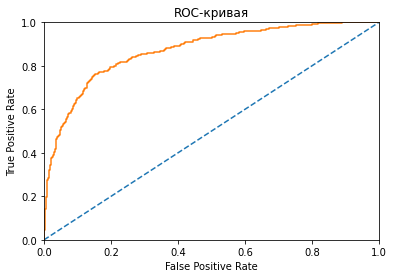

In [32]:
fpr, tpr, thresholds = roc_curve(target_valid,probabilities_one_valid)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show() 

## Общий вывод


В ходе исследования была обработана информация по клиентам «Бета-Банка» для прогнозирования их оттока. 

Для определения максимального значения *F1*-меры были построены разные модели с использованием различных алгоритмов и их параметров. Была выявлена лучшая модель алгоритма Случайный Лес и протестирована на тестовой выборке. Результат достигнут,   метрика F1 равна 0.596. Значние показателя ROC-AUC: 0.86.
